# Подгрузка данных

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib

In [39]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.max_colwidth', None)

In [3]:
df = pd.read_parquet('train_ai_comp_final_dp.parquet')

In [4]:
df.memory_usage().sum()

4489473600

Данные много весят, поэтому для ускорения работы сожмём столбцы переводом в подходящий dtype

In [5]:
for col in df.columns:
    if df[col].dtype == 'int64':
        for two in [8, 16, 32, 64]:
            if df[col].min() >= 0 and df[col].max() < 2**two:
                df[col] = df[col].astype(f'uint{two}')
                break
            elif df[col].max() < 2**(two)//2 and abs(df[col].min()) < 2**(two)//2:
                df[col] = df[col].astype(f'int{two}')
                break

In [6]:
df.memory_usage().sum()

998180415

Получилось сжать в ~4.5 раза

# Анализируем данные

In [7]:
df.head()

,id,target,sample_ml_new,feature1,feature2,feature3,feature4,feature5,feature6,feature7,feature8,feature9,feature10,feature11,feature12,feature13,feature14,feature15,feature16,feature17,feature18,feature19,feature20,feature21,feature22,feature23,feature24,feature25,feature26,feature27,feature28,feature29,feature30,feature31,feature32,feature33,feature34,feature35,feature36,feature37,feature38,feature39,feature40,feature41,feature42,feature43,feature44,feature45,feature46,feature47,feature48,feature49,feature50,feature51,feature52,feature53,feature54,feature55,feature56,feature57,feature58,feature59,feature60,feature61,feature62,feature63,feature64,feature65,feature66,feature67,feature68,feature69,feature70,feature71,feature72,feature73,feature74,feature75,feature76,feature77,feature78,feature79,feature80,feature81,feature82,feature83,feature84,feature85,feature86,feature87,feature88,feature89,feature90,feature91,feature92,feature93,feature94,feature95,feature96,feature97,feature98,feature99,feature100,feature101,feature102,feature103,feature104,feature105,feature106,feature107,feature108,feature109,feature110,feature111,feature112,feature113,feature114,feature115,feature116,feature117,feature118,feature119,feature120,feature121,feature122,feature123,feature124,feature125,feature126,feature127,feature128,feature129,feature130,feature131,feature132,feature133,feature134,feature135,feature136,feature137,feature138,feature139,feature140,feature141,feature142,feature143,feature144,feature145,feature146,feature147,feature148,feature149,feature150,feature151,feature152,feature153,feature154,feature155,feature156,feature157,feature158,feature159,feature160,feature161,feature162,feature163,feature164,feature165,feature166,feature167,feature168,feature169,feature170,feature171,feature172,feature173,feature174,feature175,feature176,feature177,feature178,feature179,feature180,feature181,feature182,feature183,feature184,feature185,feature186,feature187,feature188,feature189,feature190,feature191,feature192,feature193,feature194,feature195,feature196,feature197,feature198,feature199,feature200,feature201,feature202,feature203,feature204,feature205,feature206,feature207,feature208,feature209,feature210,feature211,feature212,feature213,feature214,feature215,feature216,feature217,feature218,feature219,feature220,feature221,feature222,feature223,feature224,feature225,feature226,feature227,feature228,feature229,feature230,feature231,feature232,feature233,feature234,feature235,feature236,feature237,feature238,feature239,feature240,feature241,feature242,feature243,feature244,feature245,feature246,feature247,feature248,feature249,feature250,feature251,feature252,feature253,feature254,feature255,feature256,feature257,feature258,feature259,feature260,feature261,feature262,feature263,feature264,feature265,feature266,feature267,feature268,feature269,feature270,feature271,feature272,feature273,feature274,feature275,feature276,feature277,feature278,feature279,feature280,feature281,feature282,feature283,feature284,feature285,feature286,feature287,feature288,feature289,feature290,feature291,feature292,feature293,feature294,feature295,feature296,feature297,feature298,feature299,feature300,feature301,feature302,feature303,feature304,feature305,feature306,feature307,feature308,feature309,feature310,feature311,feature312,feature313,feature314,feature315,feature316,feature317,feature318,feature319,feature320,feature321,feature322,feature323,feature324,feature325,feature326,feature327,feature328,feature329,feature330,feature331,feature332,feature333,feature334,feature335,feature336,feature337,feature338,feature339,feature340,feature341,feature342,feature343,feature344,feature345,feature346,feature347,feature348,feature349,feature350,feature351,feature352,feature353,feature354,feature355,feature356,feature357,feature358,feature359,feature360,feature361,feature362,feature363,feature364,feature365,feature366,feature367,feature368,feature369,feature370,feature371,fe

In [8]:
len(df[df['sample_ml_new'] == 1])

519615

In [9]:
target = df['target'].copy()

Проверим на наличие NaN

In [40]:
df.isna().sum()[df.isna().sum() > 0]

Series([], dtype: int64)

- Удалить feature 756
- Удалить feature 642 

In [11]:
df.drop(['feature756', 'feature642', 'sample_ml_new', 'id'], axis=1, inplace=True)

## Дисбаланс классов

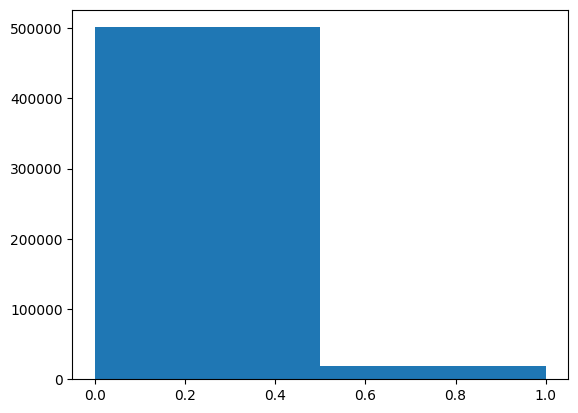

In [12]:
plt.hist(target, bins=2)
plt.show()

In [13]:
target[target == 0].count() / target[target == 1].count()

27.031234827642013

В классах присутствует дисбаланс 1 к 27

## Дисперсия значений

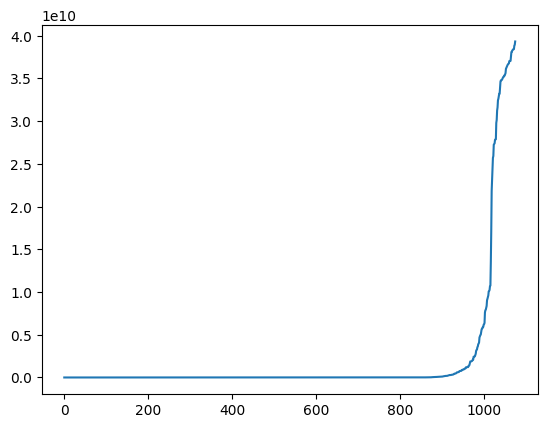

In [14]:
var = df.var()
plt.plot(sorted(list(var.values)))

В данных есть фичи с низкой дисперсией, построим более подробный график

## Собираем датафрейм с уникальными значениями для фич

In [15]:
dictionary = dict()
for col in df.columns:
    tmp = pd.unique(df[col])
    dictionary[col] = [len(set(tmp)) == len(range(tmp.min(), tmp.max() + 1)), len(set(tmp))]
unique = pd.DataFrame.from_dict(dictionary, orient='index', columns = ['cat', 'len_unique'])

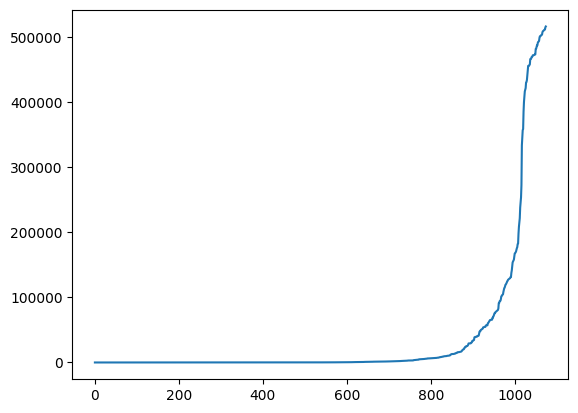

In [16]:
plt.plot(sorted(unique['len_unique'].values))
plt.show()

Много характеристик с малым количеством уникальных значений, рассмотрим интервал от 1 до 20 уникальных значений

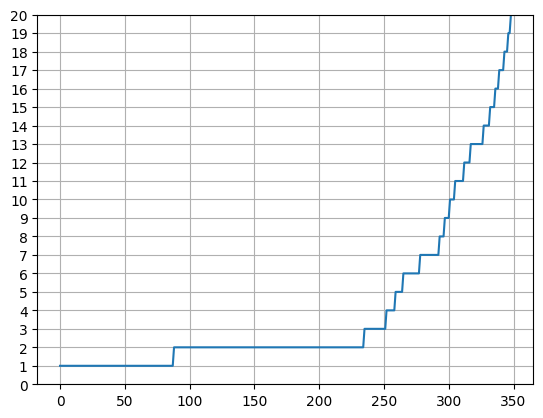

In [17]:
n = 20 + 1
ymin = 0
ymax = max(unique['len_unique'][unique['len_unique'] < n].values)
locator = matplotlib.ticker.LinearLocator(ymax + 1)

figure = plt.figure()
axes = figure.add_subplot(1, 1, 1)
axes.set_ylim(ymin, ymax)
axes.yaxis.set_major_locator(locator)
plt.plot(sorted(unique['len_unique'][unique['len_unique'] < n].values))
plt.grid()

In [18]:
for i in range(1, 11):
    print(f'Количество значений с {i} уникальных значений: {len(unique["len_unique"][(unique["len_unique"] == i)])}')

Количество значений с 1 уникальных значений: 88
Количество значений с 2 уникальных значений: 147
Количество значений с 3 уникальных значений: 17
Количество значений с 4 уникальных значений: 7
Количество значений с 5 уникальных значений: 6
Количество значений с 6 уникальных значений: 13
Количество значений с 7 уникальных значений: 15
Количество значений с 8 уникальных значений: 4
Количество значений с 9 уникальных значений: 4
Количество значений с 10 уникальных значений: 4


Удалим фичи, где 1 уникальное значение. Таких 88

In [19]:
df.drop(unique['len_unique'][(unique['len_unique'] == 1)].index.values, axis=1, inplace=True)

In [20]:
unique.drop(unique['len_unique'][(unique['len_unique'] == 1)].index.values, axis=0, inplace=True)

## Рассмотрим коллинеарность признаков

In [21]:
#corr = df.corr()

In [22]:
corr = pd.read_csv('dump_corr.csv', index_col=[0]) #Мы сделали dump, чтобы можно было подгрузить быстро, а не вычислять её

In [23]:
((corr >= 0.95).sum()-1).sum() #2846 пар фич с коллинеарность >= 0.95

2846

In [24]:
list_del_feature = []

In [25]:
for i in corr.columns:
    if i in corr.columns:
        TMP = abs(corr.loc[i])
        TMP = TMP >= 0.95
        TMP.loc[i] = False
        del_feature = list(corr[TMP].index.values)
        list_del_feature += del_feature
        corr.drop(del_feature, axis=1, inplace=True)
        corr.drop(del_feature, axis=0, inplace=True)

In [26]:
del(corr)

In [27]:
df.drop(list_del_feature, axis=1, inplace=True)

In [28]:
len(df.columns)

692

In [29]:
df.head()

,target,feature1,feature2,feature3,feature4,feature5,feature6,feature7,feature9,feature12,feature17,feature18,feature19,feature22,feature23,feature24,feature25,feature26,feature27,feature30,feature31,feature33,feature35,feature36,feature37,feature38,feature41,feature42,feature43,feature44,feature45,feature46,feature47,feature48,feature49,feature52,feature53,feature56,feature58,feature59,feature60,feature61,feature62,feature63,feature64,feature65,feature66,feature67,feature70,feature71,feature72,feature73,feature74,feature75,feature76,feature77,feature78,feature79,feature80,feature82,feature83,feature84,feature85,feature86,feature87,feature88,feature89,feature91,feature92,feature93,feature94,feature95,feature96,feature97,feature98,feature99,feature100,feature101,feature102,feature103,feature104,feature105,feature106,feature107,feature108,feature109,feature110,feature111,feature112,feature113,feature114,feature115,feature116,feature117,feature118,feature120,feature121,feature122,feature123,feature124,feature125,feature127,feature128,feature133,feature136,feature137,feature138,feature139,feature140,feature141,feature143,feature145,feature146,feature147,feature148,feature149,feature150,feature151,feature152,feature153,feature154,feature155,feature156,feature157,feature158,feature161,feature162,feature163,feature164,feature165,feature166,feature167,feature168,feature169,feature170,feature171,feature172,feature173,feature174,feature175,feature176,feature177,feature178,feature179,feature180,feature181,feature182,feature183,feature184,feature185,feature186,feature187,feature188,feature189,feature191,feature192,feature193,feature194,feature195,feature196,feature197,feature199,feature200,feature202,feature203,feature204,feature205,feature208,feature210,feature212,feature214,feature215,feature216,feature217,feature218,feature220,feature224,feature225,feature226,feature227,feature229,feature230,feature231,feature232,feature233,feature234,feature243,feature244,feature260,feature262,feature264,feature265,feature268,feature273,feature274,feature275,feature276,feature277,feature278,feature279,feature280,feature281,feature282,feature285,feature286,feature287,feature288,feature289,feature290,feature291,feature293,feature294,feature295,feature296,feature297,feature298,feature299,feature300,feature301,feature302,feature303,feature304,feature305,feature306,feature307,feature308,feature309,feature310,feature311,feature315,feature316,feature318,feature320,feature321,feature322,feature324,feature325,feature328,feature329,feature330,feature331,feature332,feature333,feature334,feature335,feature336,feature337,feature338,feature339,feature340,feature341,feature342,feature343,feature344,feature345,feature346,feature349,feature350,feature352,feature353,feature354,feature355,feature356,feature357,feature358,feature359,feature366,feature367,feature368,feature369,feature370,feature376,feature383,feature384,feature385,feature386,feature387,feature388,feature390,feature391,feature392,feature393,feature394,feature395,feature399,feature400,feature401,feature404,feature405,feature408,feature409,feature410,feature411,feature412,feature413,feature415,feature416,feature417,feature418,feature420,feature422,feature423,feature424,feature425,feature426,feature427,feature428,feature429,feature431,feature433,feature434,feature435,feature437,feature439,feature440,feature441,feature442,feature444,feature445,feature446,feature447,feature448,feature450,feature451,feature452,feature453,feature454,feature455,feature456,feature457,feature459,feature461,feature462,feature463,feature464,feature465,feature468,feature469,feature470,feature471,feature472,feature473,feature474,feature475,feature476,feature477,feature478,feature483,feature485,feature488,feature489,feature490,feature491,feature492,feature493,feature495,feature497,feature498,feature499,feature500,feature501,feature502,feature503,feature504,feature505,feature506,feature507,feature508,feature509,feature510,feature513,featu

**Получилось сократить данные почти в 2 раза с предполагаемой маленькой потерей точности в будущем**

## Категориальные данные

Попробуем угадать категориальные данные
- Если у фичи 2-5 уникальных значений, то это скорее всего категориальные данные
- Если у фичи идут подряд значения от 0 до n без пропусков, то с большей долей вероятности это тоже категориальные данные

In [30]:
dictionary = dict()
for col in df.columns:
    tmp = pd.unique(df[col])
    dictionary[col] = [len(set(tmp)) == len(range(tmp.min(), tmp.max() + 1)), len(set(tmp))]
unique = pd.DataFrame.from_dict(dictionary, orient='index', columns = ['cat', 'len_unique'])

In [31]:
cat_features_list = []
for i in range(2, 20 + 1):
    cat_features_list.append(unique['len_unique'][(unique['len_unique'] == i)].index.values)

In [32]:
n = 5
n -= 2
cat_features = []
for i in range(min(n, len(cat_features_list))):
    cat_features += list(cat_features_list[i])

In [33]:
cat_features += list(unique[unique['cat'] == True].index.values)

In [34]:
cat_features = list(set(cat_features))

In [35]:
len(cat_features)

192

## Рассмотрим распределение данных от target и feature

In [ ]:
for c1 in df.columns:
    for c2 in df.columns:
        if c2 == 'target' or c1 == c2:
            continue
        figure = plt.figure()
        axes = figure.add_subplot(1, 1, 1)
        
        plt.scatter(df[df['target'] == 0][c1], df[df['target'] == 0][c2], color='blue')
        plt.scatter(df[df['target'] == 1][c1], df[df['target'] == 1][c2], color='red')
        plt.savefig(str(c1) + str('_') + str(c2))
        plt.close(figure)
        
print(1)

### !! Готовые графики можно увидеть в папке graphics !!

Примеры важных признаков. Во время обучения модели фиче feature23, feature26, feature60 можно отдать больший вес. Таких признаков мы выделили 44

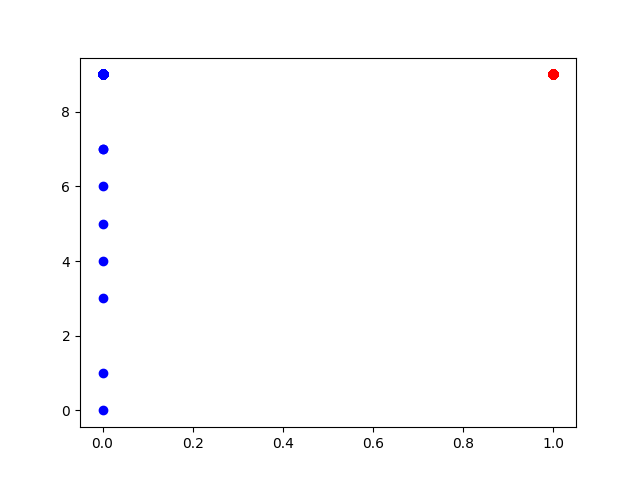

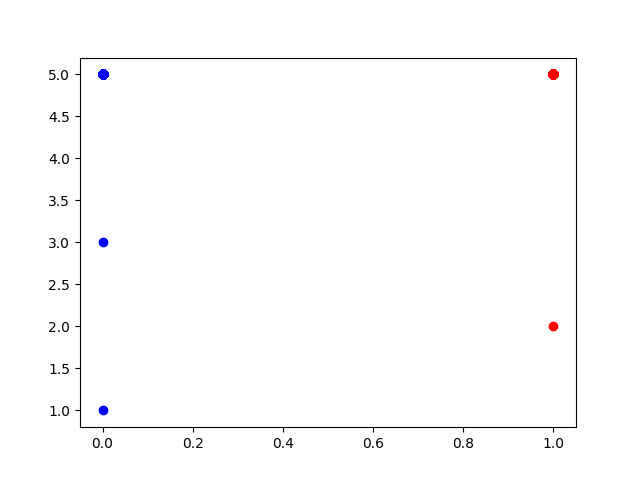

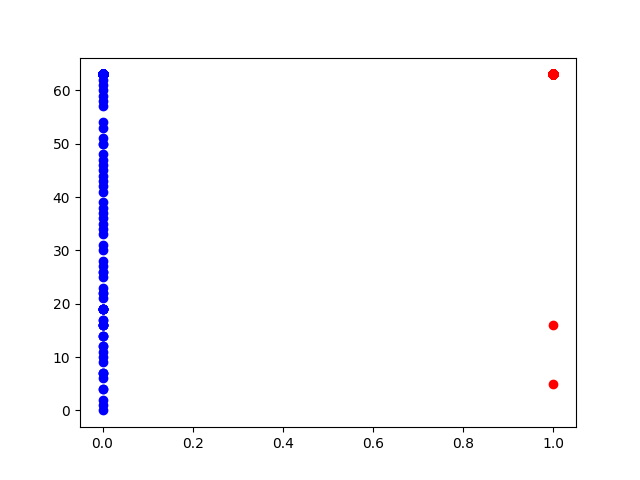

### А где были похожий разброс фич, мы не добавляли вес

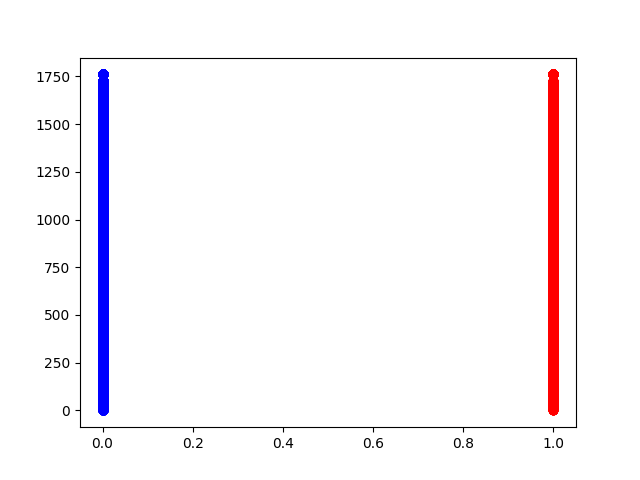

In [37]:
with open('cat_features.npy', 'wb') as f:
    np.save(f, cat_features)

In [38]:
df.to_parquet('train.parquet', compression=None)